# Main results with real dataset

Section 4.2 (Internal validation with Vital DB) in manuscript

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K,losses
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Permute, Multiply, Flatten, Add, LSTM, Bidirectional
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.losses=[]
        self.val_losses=[]
        
    def on_epoch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

### Load dataset

In [2]:
# VitalDB testEEG/BIS
testEEG = np.load('VitalDB_TestEEG.npy')
testBIS = np.load('VitalDB_TestBIS.npy')

# EEG normalization
EEGmin = -1477.0
EEGmax = 1800.0
testEEG = (testEEG - EEGmin)/(EEGmax-EEGmin)

testEEG.shape, testBIS.shape

((19253, 3000, 1), (19253, 1))

### Load model with weights

In [ ]:
Fs = 100  # Sampling frequency = 100 Hz
DimSize = 30  # Length of EEG = 30 s
SignalSize = 1  # Number of features 
EEGmin = -1477.0
EEGmax = 1800.0

Half = int(Fs/2)
InputWindowSize = Fs * DimSize
DRrate = 0.5

def SigProcessing (vector):
    Casted = tf.cast(vector, tf.complex64) 
    fft = tf.signal.fft(Casted)
    Scaled_fft =fft[:,:,:,:Half]
    Abs_fft = tf.abs(Scaled_fft)*(1/(Half*2.5)) # Relative amplitude
    Phase_ang = tf.math.angle(Scaled_fft)*180/np.pi + K.epsilon()
    return [Abs_fft,Phase_ang]

def TimeAxis(input_batch):
    np_constant = [np.arange(1,DimSize+1,1).reshape(1, DimSize) for i in range(SignalSize)]
    tf_constant = K.constant(np.concatenate(np_constant,axis=0))
    batch_size = K.shape(input_batch)[0]
    constantVal = tf.tile(tf.expand_dims(tf_constant,0), ([batch_size,1,1]))
    return constantVal


# Input : 30 s of EEG sampled at 100 Hz
InputVec = Input(shape=(InputWindowSize, SignalSize), name='Input')
PermutedDense1 = Permute((2,1), name='Permute')(InputVec)
InputReStructure =Lambda(lambda x:K.reshape(x,(-1, SignalSize, DimSize, Fs)))(PermutedDense1) 

# 1. FFT layers (Fig. 3)

Abs_fft = Lambda(SigProcessing)(InputReStructure)[0]
Phase_ang = Lambda(SigProcessing)(InputReStructure)[1]

Sig1_Amp_inp = Lambda(lambda x:x[:, 0,:,:])(Abs_fft)
Sig1_Phase_inp = Lambda(lambda x:x[:, 0,:,:])(Phase_ang)

# 2. LSTM layers (Fig. 4)

Sig1_Amp = Bidirectional(LSTM(10, dropout=DRrate, activation='softsign', return_sequences=True))(Sig1_Amp_inp, training=True)
Sig1_Phase = Bidirectional(LSTM(10, dropout=DRrate, activation='softsign', return_sequences=True))(Sig1_Phase_inp, training=True)

Sig_concat = Concatenate()([Sig1_Amp,Sig1_Phase])
Sig_concat = Bidirectional(LSTM(10, dropout=DRrate, activation='softsign', return_sequences=True))(Sig_concat, training=True)
Sig_concat = Bidirectional(LSTM(5, dropout=DRrate, activation='softsign', return_sequences=True))(Sig_concat, training=True)

Amp_out = Bidirectional(LSTM(10, dropout=DRrate, activation='softsign', return_sequences=True))(Sig_concat, training=True)
Phase_out = Bidirectional(LSTM(10, dropout=DRrate, activation='softsign', return_sequences=True))(Sig_concat, training=True)

# 3. Interpretable layers (Fig. 5)

Amp_weibul = Dense(10, activation='relu')(Amp_out)
Amp_weibul = Dense(2, activation='softplus')(Amp_weibul)
Amp_Alpha = Lambda(lambda x:x[:,0:1,0:1])(Amp_weibul)
Amp_Beta = Lambda(lambda x:x[:,0:1,1:2])(Amp_weibul)
TimeAxisVec = (Lambda(TimeAxis)(Amp_weibul))
Amp_Time_Effect = 1-tf.exp(-(TimeAxisVec/Amp_Alpha)**Amp_Beta) # amplitude time-decayed effect
Amp_out = Concatenate()([Amp_out, Amp_weibul])
Amp_att = Dense(25, activation='elu')(Amp_out)
Amp_att = Dense(Half, activation='softmax')(Amp_att) # amplitude attention

Phase_weibul = Dense(10, activation='relu')(Phase_out)
Phase_weibul = Dense(2, activation='softplus')(Phase_weibul)
Phase_Alpha = Lambda(lambda x:x[:,0:1,0:1])(Phase_weibul)
Phase_Beta = Lambda(lambda x:x[:,0:1,1:2])(Phase_weibul)
TimeAxisVec = (Lambda(TimeAxis)(Phase_weibul))
Phase_Time_Effect =1-tf.exp(-(TimeAxisVec/Phase_Alpha)**Phase_Beta) # phase time-decayed effect
Phase_out = Concatenate()([Phase_out, Phase_weibul])
Phase_att = Dense(25, activation='elu')(Phase_out)
Phase_att = Dense(Half, activation='softmax')(Phase_att) # phase attention

# 4. BIS calculation layers (Fig. 6) 

Amp_end = Multiply(name='Amp_end')([Sig1_Amp_inp, Permute((2,1))(Amp_Time_Effect), Amp_att])
Amp_end = Lambda(lambda x:tf.reduce_sum(x, axis=(1,2), keepdims=True)+K.epsilon())(Amp_end) # amplitude context
Phase_end = Multiply(name='Phase_end')([Sig1_Phase_inp,Permute((2,1))(Phase_Time_Effect), Phase_att])
Phase_end = Lambda(lambda x:tf.reduce_sum(x, axis=(1,2), keepdims=True)+K.epsilon())(Phase_end) # phase context

Out = Add()([Amp_end,Phase_end])
Out = Flatten(name='Add_end')(Out)

model = Model(InputVec, Out)

model.load_weights('./ModelResults/FinalModel_0716_4624_0.0033299_0.0032866.hdf5')
model.compile(loss= losses.mean_squared_error, optimizer='adam') 

## 4.2.1 Model Performance

#### Table 2 Model Performance of Internal Validation

Regression

In [4]:
### Divide samples into groups by BIS range ###

def divide_by_range(testEEG,testBIS,lower,upper):
    
    testBISidx = np.where((testBIS<upper) & (testBIS>=lower))[0]
    testEEG = testEEG[testBISidx]
    testBIS = testBIS[testBISidx]
    
    return testEEG, testBIS

testEEG20, testBIS20 = divide_by_range(testEEG,testBIS,0,0.2) # BIS 0 - 20
testEEG40, testBIS40 = divide_by_range(testEEG,testBIS,0.2,0.4) # BIS 20 - 40
testEEG60, testBIS60 = divide_by_range(testEEG,testBIS,0.4,0.6) # BIS 40 - 60
testEEG80, testBIS80 = divide_by_range(testEEG,testBIS,0.6,0.8) # BIS 60 - 80
testEEG100, testBIS100 = divide_by_range(testEEG,testBIS,0.8,1) # BIS 80 - 100

EEG = [testEEG20, testEEG40, testEEG60, testEEG80, testEEG100]
BIS = [testBIS20, testBIS40, testBIS60, testBIS80, testBIS100]

In [ ]:
### Get predicted BIS values for all BIS ranges ###

predClass = []
concatClass = []

for i in range(len(BIS)): 
    score_all = []
    concatScore = np.empty((len(EEG[i]),1))
    for j in range(100):
        print(str(i)+'-'+str(j))
        score = model.predict(EEG[i], batch_size=2000, verbose=1)
        concatScore = np.concatenate((concatScore, score), axis=1)
    
    concatScore = concatScore[:,1:]
    meanScore = np.mean(concatScore, axis=1).reshape(-1)
    
    concatClass.append(concatScore)
    predClass.append(meanScore)
    
predClass = np.concatenate(predClass, axis=0)
concatClass = np.concatenate(concatClass, axis=0)
np.save('./ProcessedData/VitalDB_TestBISpred.npy', predClass)
np.save('./ProcessedData/VitalDB_TestBISconcat.npy', concatClass)

In [6]:
### Compute mean & std for all BIS ranges ###

predClass = np.load('./ProcessedData/VitalDB_TestBISpred.npy', allow_pickle=True)
concatClass = np.load('./ProcessedData/VitalDB_TestBISconcat.npy', allow_pickle=True)

setLEN = [obs.shape[0] for obs in BIS]
setIDX = setLEN.copy()
for i in range(len(BIS)-1):
    setIDX[i+1] = setIDX[i] + setIDX[i+1]
setIDX = setIDX[:-1]

predBIS = np.split(predClass, list(setIDX))
concatBIS = np.split(concatClass, list(setIDX))

def rmean(y_true, y_pred) :
    return np.sqrt(np.mean(np.square(y_pred-y_true)))
def rvar(y_true, y_pred) :
    return np.sqrt(np.var(np.square(y_pred-y_true)))

scoreRMEAN = [rmean(predBIS[i], BIS[i].squeeze()) for i in range(len(BIS))]
scoreRVAR = [rvar(predBIS[i], BIS[i].squeeze()) for i in range(len(BIS))]

In [7]:
pd.DataFrame([scoreRMEAN, scoreRVAR], index=['mean','std'], columns=['0-19','20-39','40-59','60-79','80-100'])*100

,0-19,20-39,40-59,60-79,80-100
mean,4.809980,4.913548,4.342723,5.880948,5.427756
std,1.115828,0.589749,0.371660,1.054420,0.849319


Classification at BIS60

In [8]:
predBIS_All = np.concatenate(predBIS, axis=0)
actBIS_All = np.concatenate(BIS, axis=0).squeeze()

predClass = np.where(predBIS_All>=0.6,1,0)
actClass = np.where(actBIS_All>=0.6, 1, 0).squeeze()

acc = accuracy_score(actClass, predClass)
auroc = roc_auc_score(actClass, predBIS_All)
sens = recall_score(actClass, predClass, pos_label=1)
spec = confusion_matrix(actClass, predClass).ravel()
spec = spec[0]/(spec[0]+spec[1])

print('Accuracy : ', acc)
print('AUROC : ', auroc)
print('Sensitivity : ', sens)
print('Specificity : ', spec)

Accuracy :  0.9522152391835038
AUROC :  0.9919354751583317
Sensitivity :  0.9234165861735891
Specificity :  0.9695985340663001


## 4.2.2 Model Interpretation

#### 4.2.2.1 Visualization of attention values

In [ ]:
### extract attention layer form the model and predict 100 times ###

def get_att(att):
    
    # attention layer * time decay effect
    if att == 0: # amplitude att
        FFT_effect = Multiply(name='Amp_end')([Permute((2,1))(Amp_Time_Effect), Amp_att])
    else: # phase att
        FFT_effect = Multiply(name='Phase_end')([Permute((2,1))(Phase_Time_Effect), Phase_att])
    FFT_Model = Model(InputVec, FFT_effect)

    # predict 
    AttVis = []
    for i in range(len(BIS)):
        res_all = []
        for j in range(100): 
            res_end = FFT_Model.predict(EEG[i], batch_size=10000, verbose=1)
            res_end = np.mean(res_end, axis=0)
            res_all.append(res_end)
        res_all = np.mean(np.array(res_all), axis=0)
        AttVis.append(res_all) 
    
    return np.array(AttVis)

np.save('./ProcessedData/VitalDB_AttAmp.npy', get_att(0))  # save amplitude attention values
np.save('./ProcessedData/VitalDB_AttPhase.npy', get_att(1)) # save phase attention values

In [9]:
### visualize attention values ###

def visualize_att(att):

    if att == 0: # amplitude att
        AttVis = np.load('./ProcessedData/VitalDB_AttAmp.npy')
        ticks=[0.00,0.01,0.02,0.03,0.04,0.05]
    else: # phase att
        AttVis = np.load('./ProcessedData/VitalDB_AttPhase.npy')
        ticks=[0.000000,0.000001,0.000002,0.000003,0.000004,0.000005]
        
    fig = plt.figure(figsize=(30,3))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(AttVis[i,:,1:])
        plt.yticks(fontsize='xx-large')
        plt.clim(0,ticks[-1])
        plt.xticks(np.arange(0, 50, 10), labels=['1','11','21','31','41'], fontsize='xx-large')
        cb = plt.colorbar(ticks=ticks)
        cb.ax.set_yticklabels(labels = [str(i) for i in cb.get_ticks()], fontsize='xx-large')

#### Fig. 8.  Attention values of internal validation

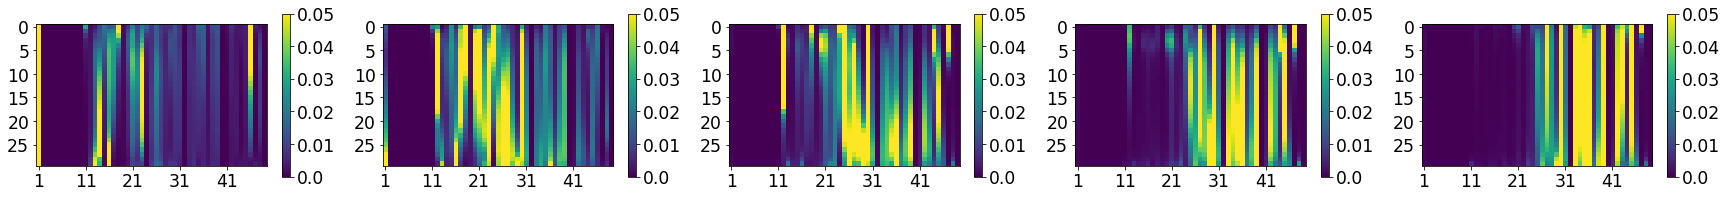

In [10]:
visualize_att(0) # amplitude attention

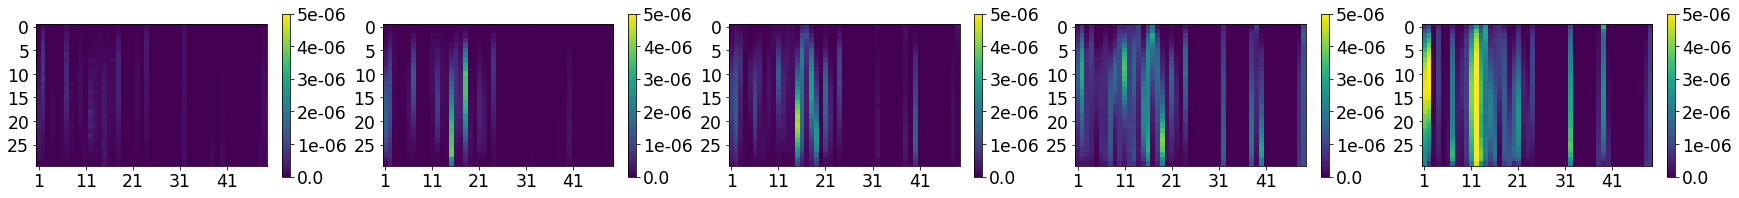

In [11]:
visualize_att(1) # phase attention

# End